<a href="https://colab.research.google.com/github/leowu4ever/PhD_Note/blob/master/experiments_breathing_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Housekeeping**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

import librosa
import librosa.display

import numpy as np
from pathlib import Path

import IPython

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!pip install pyhht
import pyhht

import pywt

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.insert(0,'/content/gdrive/My Drive/colab PhD')

import os

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path_gdrive = '/content/gdrive/My Drive/colab PhD/'
path_gdrive_clips = path_gdrive + 'clips/'
path_gdrive_plots = path_gdrive + 'plots/'
path_gdrive_train_audio = path_gdrive + 'train_audio/'
path_gdrive_train_audio_in = path_gdrive_train_audio + 'in/'
path_gdrive_train_audio_out = path_gdrive_train_audio + 'out/'

path_gdrive_train_img = path_gdrive + 'train_img/'
path_gdrive_train_img_in = path_gdrive_train_img + 'in/'
path_gdrive_train_img_out = path_gdrive_train_img + 'out/'

path_gdrive_valid_img = path_gdrive + 'valid_img/'
path_gdrive_valid_img_in = path_gdrive_valid_img + 'in/'
path_gdrive_valid_img_out = path_gdrive_valid_img + 'out/'

path_gdrive_models = path_gdrive + 'models/'

file_names = [path_gdrive_clips + 'My memos 7.wav', 
              path_gdrive_clips + 'My memos 8.wav', 
              path_gdrive_clips + 'My memos 9.wav', 
              path_gdrive_clips + 'My memos 10.wav', 
              path_gdrive_clips + 'test_clip_1.wav', 
              path_gdrive_clips + 'test_clip_2.wav', 
              path_gdrive_clips + 'test_clip_3.wav'];
# file_names = [path_gdrive_clips + 'My memos 7.wav', path_gdrive_clips + 'My memos 8.wav', path_gdrive_clips + 'My memos 9.wav', path_gdrive_clips + 'My memos 10.wav'];


file_count = len(file_names)

def create_paths(file_names):
  clips = []
  rates = []
  for file_name in file_names:
    clip_path = Path(file_name)
    clip, rate = librosa.load(clip_path)
    
    clips.append(clip)
    rates.append(rate)

  return clips, rates

clips, rates = create_paths(file_names)
sr = rates[0]

In [0]:
xlines_breathing_in = np.array([
    [0.6, 5.5, 6.9, 9, 10.5, 12.8, 14.3, 16.8, 18.8, 20.3, 23],
    [0.3, 3.5, 5.7, 8.2, 10.3, 11.8, 14.4, 17.3, 19.1, 20.9, 22.5, 24.6, 26.5, 28.4, 30.7, 32.9, 34.9, 37, 39.2, 41, 42.2],
    [3.8, 5.7, 8.1, 11.4, 14, 16.6, 19.3, 23, 26.9, 30.7],
    [5.5, 7.7, 10.1, 12.1, 14.3, 16.8, 27, 45, 56.5],
    [],
    [0.5, 2.5, 4, 5.8, 7.4],
    [1, 2.9, 5.3, 7.1, 9.6], 
])

xlines_breathing_out = np.array([
    [2.7, 6.3, 8, 9.8, 11.6, 13.3, 15.3, 17.8, 19.7, 21.3],
    [1.6, 4.2, 6.6, 9.3, 11, 13.1, 15.9, 18.4, 20.1, 21.7, 23.6, 25.4, 27.5, 29.4, 31.7, 34, 36.1, 38, 39.8, 41.7, 43.2],
    [4.2, 6.8, 9.4, 12.7, 15.5, 17.8, 20.6, 25.2, 27.9, 33.4],
    [6.5, 8.7, 11.4, 13.2, 15.3, 17.5, 20.8, 23.6, 28.3, 33.4, 44, 46.6, 57.3],
    [2.2, 5.3, 8.2, 11, 14, 16.7],
    [1.4, 3.2, 5, 6.6, 7.9],
    [1.9, 3.8, 6, 8.2, 10.4],
    
])

In [0]:
segmentation_size = 256
overlapping_perc = 0.25
imf_iteration_limit = 100

# **Plotting functions**

In [0]:
def display_fft(clip):
    if(len(clip)%2 != 0):
      clip = np.append(clip, [0])
      
    fft = scipy.fftpack.fft(clip)
    num_of_samples = len(clip)
    fft_freq = scipy.fftpack.fftfreq(num_of_samples, 1/sr)
    plt.xlim(0,8000)
    plt.plot(fft_freq[0:int(num_of_samples/2)], (abs(fft)/num_of_samples)[0:int(num_of_samples/2)])

In [0]:
def display_audio_files(file_names):
  for file_name in file_names:
    print(file_name)
    IPython.display.display(IPython.display.Audio(file_name))

In [0]:
def display_audio_waveform(clips):
  for clip in clips:
    plt.figure(figsize=(20,4))
    librosa.display.waveplot(clip)

In [0]:
def display_stft_spectrograms(clips, breathing_in_displayed=False, breathing_out_displayed=False, title=None, spectrogram_width=20, spectrogram_height=4):
  i = 0
  fig, ax = plt.subplots(1, file_count, figsize=(spectrogram_width,spectrogram_height))

  for j in range(len(clips)):
    clip_stft = librosa.stft(clips[j], window='hamm')
    clip_stft_mag, clip_stft_phase = librosa.magphase(clip_stft)
    clip_stft_mag_db = librosa.amplitude_to_db(clip_stft_mag, ref=np.max)
    
    if(file_count == 1):
      librosa.display.specshow(clip_stft_mag_db, x_axis='time', y_axis='linear', ax=ax)

      ax.set_title(title + file_names[i] + " --- yellow line for breathing in, red line for breathing out")
      
      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax.axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax.axvline(xline_breathing_out, c='r') 
        
    else:
      librosa.display.specshow(clip_stft_mag_db, x_axis='time', y_axis='linear', ax=ax[i])
      
      ax[i].set_title(title + file_names[i].split('/')[-1] + " --- yellow line for breathing in, red line for breathing out")
    
      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax[i].axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax[i].axvline(xline_breathing_out, c='r') 
        
    i=i+1

In [0]:
def display_mel_spectrograms(clips, breathing_in_displayed=False, breathing_out_displayed=False, title=None, spectrogram_width=20, spectrogram_height=4):
  i = 0
  fig, ax = plt.subplots(1,file_count, figsize=(spectrogram_width,spectrogram_height))
  
  for j in range(len(clips)):
    clip_mel_spec = librosa.feature.melspectrogram(clips[j])
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)
    
    if(file_count == 1):
      librosa.display.specshow(clip_mel_spec_db, x_axis='time', y_axis='mel', ax=ax)
      
      ax.set_title(title + file_names[i] + " --- yellow line for breathing in, red line for breathing out")

      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax.axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax.axvline(xline_breathing_out, c='r') 
        
    else:
      librosa.display.specshow(clip_mel_spec_db, x_axis='time', y_axis='mel', ax=ax[i])
      
      ax[i].set_title(title + file_names[i].split('/')[-1] + " --- yellow line for breathing in, red line for breathing out")
      
      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax[i].axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax[i].axvline(xline_breathing_out, c='r') 
          
    i = i+1

# **Pre-processing**

In [0]:
def bandpass_filter(clips, low_frequency=50, high_frequency=4000, order=6):
  bandpass_filtered_clips = []
  
  for clip in clips:
    
    b,a=scipy.signal.butter(N=order, Wn=[2*low_frequency/sr, 2*high_frequency/sr], btype='band')
    x = scipy.signal.lfilter(b,a,clip)
    
    bandpass_filtered_clips.append(np.array(x))
  return bandpass_filtered_clips

In [0]:
def pre_emphasize(clips):
  pre_emphasized_clips = []
  
  for clip in clips:
    pre_emphasized_clip = []
    
    for i in range(1, len(clip)-1):
      pre_emphasized_sample = clip[i] - 0.96*clip[i-1]
      pre_emphasized_clip.append(pre_emphasized_sample)
      
    pre_emphasized_clips.append(np.array(pre_emphasized_clip))
    
  return pre_emphasized_clips

In [0]:
def normalise(clips):
  normalised_clips = []
  
  for clip in clips:   
    normalised_clip = librosa.util.normalize(clip)
    normalised_clips.append(normalised_clip)
    
  return normalised_clips   

In [0]:
# could try segmentation size of 256 and 600
def segment(clips, segmentation_size=256, overlapping_perc=0.25):
  
  segmented_clips = []
  for clip in clips:
    
    segmented_clip = []
    
    for i in np.arange(0, len(clip), int(segmentation_size*(1-overlapping_perc))):
        
        segmentation_start_point = i
        segmentation_end_point = segmentation_start_point + segmentation_size
        
        if(segmentation_end_point > len(clip)-1):
          
          extra_zeros = np.zeros((segmentation_end_point-len(clip))+1) 
          segmentation_end_point = len(clip)-1
          
        segmented_clip.append(np.array(clip[segmentation_start_point:segmentation_end_point]))
        
        if(segmentation_end_point == len(clip)-1):
          segmented_clip[-1] = np.append(segmented_clip[-1], extra_zeros)
          
    segmented_clips.append(segmented_clip) 
  return segmented_clips

In [0]:
def hamming_window(clips):
  
  hamming_windowed_clips = []
  for clip in clips:
    
    hamming_windowed_clip = []
    for segmentation in clip:
      len_hamming_window = len(segmentation)
      hamming_window = np.hamming(len_hamming_window)
      segmentation = segmentation * hamming_window
      
      hamming_windowed_clip.append(segmentation)
      
    hamming_windowed_clips.append(np.array(hamming_windowed_clip))
  return hamming_windowed_clips    

In [0]:
def hilbert_transform(clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False):
  hilbert_transformed_clips = []
  
  for clip in clips:
    
    if(emd_enabled):
      emd = pyhht.emd.EMD(clip, fixe=imf_iteration_limit)
      imfs = emd.decompose()
      #need to rework when having multiple imfs
      hilbert_tranformed_clip = hilbert_transform_with_zero_padding(imfs[0], amplitude_envelope_returned, instantaneous_frequency_returned)
    else:
      hilbert_tranformed_clip = hilbert_transform_with_zero_padding(clip, amplitude_envelope_returned, instantaneous_frequency_returned)
    
    hilbert_transformed_clips.append(hilbert_tranformed_clip)

  return hilbert_transformed_clips

In [0]:
def hilbert_transform_with_zero_padding(signal, amplitude_envelope_returned=True, instantaneous_frequency_returned=False):
  padding = np.zeros(int(2 ** np.ceil(np.log2(len(signal)))) - len(signal))
  tohilbert = np.hstack((signal, padding))

  analytic_signal = scipy.signal.hilbert(tohilbert)

  analytic_signal = analytic_signal[0:len(signal)]
  
  amplitude_envelope = np.abs(analytic_signal)
  instantaneous_phase = np.unwrap(np.angle(analytic_signal))
  instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * sr)

  if(amplitude_envelope_returned):
    return amplitude_envelope
  
  if(instantaneous_frequency_returned):
    return instantaneous_frequency

# **Audio feature extraction**

Energy

In [0]:
def get_segmentation_short_time_energy(clips):
  clips_energy = []
  for clip in clips:
   
    clip_energy = []
    for segmentation in clip:
      energy = np.sum(np.square(segmentation))
      clip_energy.append(energy)
    
    normalized_clip_energy = clip_energy
    clips_energy.append(np.array(normalized_clip_energy))
  return clips_energy

Spectral bandwidth

In [0]:
def get_segmentation_spectral_bandwidth(segmented_clips, plots_displayed=False):
  clips_spectral_bandwidth = []
  for clip in segmented_clips:
    
    clip_spectral_bandwidth = []
    for segmentation in clip:
      spectral_bandwidth = librosa.feature.spectral_bandwidth(segmentation, sr)
      clip_spectral_bandwidth.append(spectral_bandwidth)
    
    clips_spectral_bandwidth.append(np.array(clip_spectral_bandwidth))
  return clips_spectral_bandwidth

Spectral rolloff

In [0]:
def get_segmentation_spectral_rolloff(segmented_clips, plots_displayed=False):
  clips_spectral_rolloff = []
  for clip in segmented_clips:
    
    clip_spectral_rolloff = []
    for segmentation in clip:
      spectral_rolloff = librosa.feature.spectral_rolloff(segmentation, sr)
      clip_spectral_rolloff.append(spectral_rolloff)
    
    clips_spectral_rolloff.append(np.array(clip_spectral_rolloff))
  return clips_spectral_rolloff

Spectral centroid

In [0]:
def get_segmentation_spectral_centroid(segmented_clips, plots_displayed=False):
  clips_spectral_centroid = []
  for clip in segmented_clips:
    
    clip_spectral_centroid = []
    for segmentation in clip:
      spectral_centroid = librosa.feature.spectral_centroid(segmentation, sr)
      clip_spectral_centroid.append(spectral_centroid)
    
    clips_spectral_centroid.append(np.array(clip_spectral_centroid))
  return clips_spectral_centroid

Spectral contrast

In [0]:
def get_segmentation_spectral_contrast(segmented_clips, plots_displayed=False):
  clips_spectral_contrast = []
  for clip in segmented_clips:
    
    clip_spectral_contrast = []
    for segmentation in clip:
      spectral_contrast = librosa.feature.spectral_contrast(segmentation, sr)
      clip_spectral_contrast.append(spectral_contrast)
    
    clips_spectral_contrast.append(np.array(clip_spectral_contrast))
  return clips_spectral_contrast

Spectral flatness

In [0]:
def get_segmentation_spectral_flatness(segmented_clips, plots_displayed=False):
  clips_spectral_flatness = []
  for clip in segmented_clips:
    
    clip_spectral_flatness = []
    for segmentation in clip:
      spectral_flatness = librosa.feature.spectral_flatness(segmentation)
      clip_spectral_flatness.append(spectral_flatness)
    
    clips_spectral_flatness.append(np.array(clip_spectral_flatness))
  return clips_spectral_flatness

MFCC

In [0]:
def get_segmentation_mfcc(segmented_clips, plots_displayed=False):
  clips_mfcc = []
  for clip in segmented_clips:
    
    clip_mfcc = []
    for segmentation in clip:
      mfcc = librosa.feature.mfcc(segmentation, sr)
      clip_mfcc.append(mfcc)
      
    clips_mfcc.append(np.array(clip_mfcc))  
  return clips_mfcc

MFCC delta

In [0]:
def get_segmentation_mfcc_delta(segmented_clips, mode='nearest', plots_displayed=False):
  clips_mfcc_delta = []
  for clip in segmented_clips:
    
    clip_mfcc_delta = []
    for segmentation in clip:
      mfcc = librosa.feature.mfcc(segmentation, sr)
      mfcc_delta = librosa.feature.delta(mfcc, mode=mode)
      clip_mfcc_delta.append(mfcc_delta)
      
    clips_mfcc_delta.append(np.array(clip_mfcc_delta))  
  return clips_mfcc_delta

MFCC delta delta

In [0]:
def get_segmentation_mfcc_delta_delta(segmented_clips, mode='nearest', plots_displayed=False):
  clips_mfcc_delta_delta = []
  for clip in segmented_clips:
    
    clip_mfcc_delta_delta = []
    for segmentation in clip:
      mfcc = librosa.feature.mfcc(segmentation, sr)
      mfcc_delta_delta = librosa.feature.delta(mfcc, mode=mode, order=2)
      clip_mfcc_delta_delta.append(mfcc_delta_delta)
      
    clips_mfcc_delta_delta.append(np.array(clip_mfcc_delta_delta))  
  return clips_mfcc_delta_delta

Silent ratio (silent frame/total frame)

Normalise all of the features on the training set

# **Statistic feature extraction**

In [0]:
def energy_filter(segmented_clips, clips_energy, energy_threshold=0.2):
  clips_energy_positions_filtered = []
  for clip_energy in clips_energy:
    clips_energy_positions_filtered.append(np.asarray(np.where(clip_energy >= energy_threshold))[0])
  
  
  segmented_clips_filtered = []
  for i in range(len(segmented_clips)):
    segmented_clip_filtered = []
    for position in clips_energy_positions_filtered[i]:
      segmented_clip_filtered.append(np.array(segmented_clips[i][position]))
    segmented_clips_filtered.append(np.array(segmented_clip_filtered))

  clips_energy_filtered = []
  for i in range(len(clips_energy)):
    clip_energy_filtered = []
    for position in clips_energy_positions_filtered[i]:
      clip_energy_filtered.append(np.array(clips_energy[i][position]))
    clips_energy_filtered.append(np.array(clip_energy_filtered))
  
  return segmented_clips_filtered, clips_energy_filtered, clips_energy_positions_filtered

In [0]:
def get_feature_mean(segmented_clips_feature):
  segmented_clips_feature_mean = []
  for segmented_clip_feature in segmented_clips_feature:
    
    segmented_clip_feature_mean = []
    for segmentation_feature in segmented_clip_feature:
      mean_feature = np.mean(segmentation_feature)
      segmented_clip_feature_mean.append(np.array(mean_feature))
    
    segmented_clips_feature_mean.append(np.array(segmented_clip_feature_mean))
  return segmented_clips_feature_mean

In [0]:
def get_feature_std(segmented_clips_feature):
  segmented_clips_feature_std = []
  for segmented_clip_feature in segmented_clips_feature:
    
    segmented_clip_feature_std = []
    for segmentation_feature in segmented_clip_feature:
      std_feature = np.std(segmentation_feature)
      segmented_clip_feature_std.append(np.array(std_feature))
    
    segmented_clips_feature_std.append(np.array(segmented_clip_feature_std))
  return segmented_clips_feature_std

# Completed pipelines

In [0]:
bandpass_filtered_clips = bandpass_filter(clips)
pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)

hilbert_transformed_clips = hilbert_transform(clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
normalised_clips = normalise(hilbert_transformed_clips)
segmented_clips = segment(normalised_clips, segmentation_size, overlapping_perc)
hamming_windowed_clips = hamming_window(segmented_clips)

#filter voiced/non-voiced segmentation with time-series energy
clips_energy = get_segmentation_short_time_energy(hamming_windowed_clips)
segmented_clips_filtered_with_energy, _, _ = energy_filter(segmented_clips, clips_energy, 0.2)

In [0]:
# segmented_clips_spectral_bandwidth = get_segmentation_spectral_bandwidth(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_rolloff = get_segmentation_spectral_rolloff(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_centroid = get_segmentation_spectral_centroid(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_contrast = get_segmentation_spectral_contrast(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_flatness = get_segmentation_spectral_flatness(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_mfcc = get_segmentation_mfcc(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_mfcc_delta = get_segmentation_mfcc_delta(segmented_clips_filtered_with_energy)
# segmented_clips_spectral_mfcc_delta_delta = get_segmentation_mfcc_delta_delta(segmented_clips_filtered_with_energy)

# **Plots for revisiting**

In [0]:
#@title Default title text { run: "auto" }
run_stft_plots = False #@param {type:"boolean"}


energy_threshold = 0.2 #@param {type:"number"}
clip_num = 0 #@param {type:"integer"}

breathing_in_displayed = True #@param {type:"boolean"}
breathing_out_displayed = True #@param {type:"boolean"}
seg_pos_larger_than_energy_threshold_displayed = False #@param {type:"boolean"}


if(run_stft_plots):
  plt.figure(figsize=(20,5))
  plt.plot(clips_energy[clip_num])

  results = []
  for clip_energy in clips_energy:
    results.append(np.asarray(np.where(get_feature_mean(clips_energy)[clip_num] > energy_threshold)[0]))

  plt.title("clips_energy, segmentation that satisfy: " + str(len(results[0])))

  if(seg_pos_larger_than_energy_threshold_displayed):
    plt.axhline(energy_threshold, c='g')
    for r in results[clip_num]:
      plt.axvline(r, c='b')

  if breathing_out_displayed:
    for x in xlines_breathing_out[clip_num]:
      x = x / ((segmentation_size* (1-overlapping_perc)) / sr)
      plt.axvline(x, c='r')

  if breathing_in_displayed:
    for x in xlines_breathing_in[clip_num]:
      x = x / ((segmentation_size* (1-overlapping_perc)) / sr)
      plt.axvline(x, c='y')


  display_audio_waveform(np.array([clips[clip_num]]))

  if(seg_pos_larger_than_energy_threshold_displayed):
    for r in results[clip_num]:
      v_pos = r * (segmentation_size* (1-overlapping_perc)) / sr
      plt.axvline(v_pos, c='b')

  if breathing_out_displayed:
    for x in xlines_breathing_out[clip_num]:
      plt.axvline(x, c='r')

  if breathing_in_displayed:
    for x in xlines_breathing_in[clip_num]:
      plt.axvline(x, c='y')

In [0]:
#@title Display spectrogram of the signal with breathing_in and breathing_out markers { run: "auto", vertical-output: true }
run_mel_plots = False #@param {type:"boolean"}

breathing_in_displayed = True #@param {type:"boolean"}
breathing_out_displayed = True #@param {type:"boolean"}
spectrogram_width = 40 #@param {type:"integer"}
spectrogram_height = 4 #@param {type:"integer"}
plot_type = "all" #@param ["None","clips", "filtered_clips", "pre_emphasized_clips", "normalised_clips", "all"]

if(run_mel_plots):
  filtered_clips = bandpass_filter(clips)
  pre_emphasized_clips = pre_emphasize(filtered_clips)
  normalised_clips = normalise(pre_emphasized_clips)


  if(plot_type == 'clips'):
    display_stft_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)

  if(plot_type == 'filtered_clips'):
    display_stft_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips",spectrogram_width, spectrogram_height)

  if(plot_type == 'pre_emphasized_clips'):
    display_stft_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)

  if(plot_type == 'normalised_clips'):
    display_stft_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)

  if(plot_type == 'all'):
    display_stft_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)

    display_stft_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips",spectrogram_width, spectrogram_height)

    display_stft_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)

    display_stft_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)

# Testing parameters for spectrogram techniques

In [0]:
#@title fft
run_fft = False #@param {type:"boolean"}

if(run_fft):
  plt.figure(figsize=(20,20))

  i = 1
  for clip in clips:

    plt.subplot(len(clips), 1, i)
    display_fft(clip)
    plt.title('fft' + file_names[i-1])

    i=i+1

  plt.suptitle('fft ', size=20)
  plt.savefig(path_gdrive_plots+'fft.png');

In [0]:
#@title fft for the pipeline
run_fft_pipieline = False #@param {type:"boolean"}
fft_pipeline_clip_id = 0 #@param {type:"integer"}

if(run_fft_pipieline):
  plt.figure(figsize=(20,20))

 
  plt.subplot(4, 1, 1)
  display_fft(clips[fft_pipeline_clip_id])
  plt.title('fft')
  
  plt.subplot(4, 1, 2)
  display_fft(bandpass_filtered_clips[fft_pipeline_clip_id])
  plt.title('fft')
  
  plt.subplot(4, 1, 3)
  display_fft(pre_emphasized_clips[fft_pipeline_clip_id])
  plt.title('fft')
  
  plt.subplot(4, 1, 4)
  display_fft(normalised_clips[fft_pipeline_clip_id])
  plt.title('fft')

  i=i+1

  plt.suptitle('fft_pipeline', size=20)
  plt.savefig(path_gdrive_plots+'fft_pipeline.png');

In [0]:
0#@title test stft n_fft
run_stft_nfft = False #@param {type:"boolean"}

if(run_stft_nfft):
  power = range(5,13)
  n_ffts = np.power(2,power)
  plt.figure(figsize=(20,20))

  i = 1
  for n_fft in n_ffts:

    stft = abs(librosa.stft(normalised_clips[0], center=False, n_fft=n_fft))
    stft_mag, _ = librosa.magphase(stft)
    stft_mag_db = librosa.amplitude_to_db(stft_mag)

    plt.subplot(len(n_ffts), 1, i)
    librosa.display.specshow(stft_mag_db, cmap='magma', y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('n_fft' + str(n_fft))

    i=i+1

  plt.suptitle('stft of ' + file_names[0] + 'with differnt n_fft', size=20)
  plt.savefig(path_gdrive_plots+'stft_n_fft.png');

0

In [0]:
#@title test mel n_fft
run_mel_nfft = False #@param {type:"boolean"}

if(run_mel_nfft):

  n_ffts = np.power(2,power)
  plt.figure(figsize=(20,20))

  i = 1
  for n_fft in n_ffts:

    clip_mel_spec = librosa.feature.melspectrogram(clips[1], power=2)
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)

    plt.subplot(len(n_ffts), 1, i)
    librosa.display.specshow(clip_mel_spec_db, cmap='magma', y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('n_fft' + str(n_fft))

    i=i+1

  plt.suptitle('mel stft of ' + file_names[0] + 'with differnt n_fft', size=20)
  plt.savefig(path_gdrive_plots+'mel_stft_n_fft.png');

In [0]:
#@title test wavelet scales
run_wavelet_scales = False #@param {type:"boolean"}

if(run_wavelet_scales):
  
  plt.figure(figsize=(20,20))
  scales_limit = 20

  for i in range(scales_limit):

    plt.subplot(scales_limit, 1, i+1)

    coef, freqs = pywt.cwt(clips[0], np.arange(1,i), 'gaus1')
    plt.imshow(coef, aspect='auto', cmap='PRGn');
    plt.colorbar()
    plt.title('scales' + str(i))

  plt.suptitle('wavelet transform' + file_names[0] + 'with different scales', size=20)
  plt.savefig(path_gdrive_plots+'wavelet_trans_scales.png');

In [0]:
#@title test wavelet funcs
run_wavelet_funs = False #@param {type:"boolean"}

if(run_wavelet_funs):
  
  plt.figure(figsize=(20,20))
  wavelets = pywt.wavelist('gaus') + pywt.wavelist('mexh') + pywt.wavelist('morl')
  i=1
  for wavelet in wavelets:

    plt.subplot(len(wavelets), 1, i)

    coef, freqs = pywt.cwt(clips[0], np.arange(1,20), wavelet)
    plt.imshow(coef, aspect='auto', cmap='PRGn');
    plt.colorbar()
    plt.title('wavlet: ' + wavelet)

  #   for xline_breathing_out in xlines_breathing_out[0]:
  #     plt.axvline(xline_breathing_out*sr, c='r')

    i=i+1

  plt.suptitle('wavelet transform' + file_names[0] + 'with different wavelet functions', size=20)
  plt.savefig(path_gdrive_plots+'wavelet_trans_wav_func.png');

# Exporting

use the marker and get the first following second of samples

In [0]:
#@title Export audio files { form-width: "20%" }
run_export = True #@param {type:"boolean"}
file_length_sec = 1


if(run_export):
  for clip_id in range(len(file_names)):
    for xline_breathing_in in xlines_breathing_in[clip_id]:
      export_file_name = str(clip_id) + '_' + str(xline_breathing_in)+'.wav'
      file_start_sample = int(xline_breathing_in*sr)
      file_end_sample = int( (xline_breathing_in+file_length_sec)*sr )
      export_file_sample = clips[clip_id][file_start_sample:file_end_sample]
      librosa.output.write_wav(path_gdrive_train_audio_in+export_file_name, export_file_sample, sr)

    for xline_breathing_out in xlines_breathing_out[clip_id]:
      export_file_name = str(clip_id) + '_' + str(xline_breathing_out)+'.wav'
      file_start_sample = int(xline_breathing_out*sr)
      file_end_sample = int( (xline_breathing_out+file_length_sec)*sr )
      export_file_sample = clips[clip_id][file_start_sample:file_end_sample]
      librosa.output.write_wav(path_gdrive_train_audio_out+export_file_name, export_file_sample, sr)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 0.3250793650793651, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 0.3947392290249433, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

(0.0, 1.0216780045351475, 0.0, 11025.0)

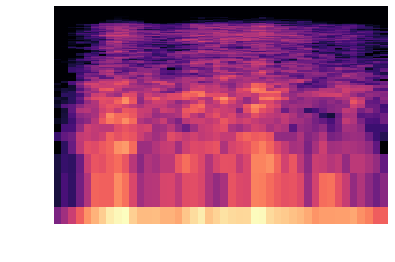

In [0]:
#@title read WAVs then generate IMGs for in and out { form-width: "20%" }
run_img_export = True #@param {type:"boolean"}

if(run_img_export):
  temp_in_clips = []
  temp_in_files = []

  
#   loading clips

  for filename in os.listdir(path_gdrive_train_audio_in):
      if filename.endswith("wav"):
        temp_in_files.append(filename)
        temp_in_clip, temp_sr = librosa.load(path_gdrive_train_audio_in + filename)
        temp_in_clips.append(temp_in_clip)


  temp_out_clips = []
  temp_out_files = []

  for filename in os.listdir(path_gdrive_train_audio_out):
      if filename.endswith("wav"):
        temp_out_files.append(filename)
        temp_out_clip, temp_sr = librosa.load(path_gdrive_train_audio_out + filename)
        temp_out_clips.append(temp_out_clip)



#         process clips with pre pro-processing approaches

  bandpass_filtered_clips = bandpass_filter(temp_in_clips)
  pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)
  hilbert_transformed_clips = hilbert_transform(pre_emphasized_clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
  normalised_clips = normalise(hilbert_transformed_clips)

  
  
  for i in range(len(temp_in_clips)):

    clip_mel_spec = librosa.feature.melspectrogram(normalised_clips[i])
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)

    librosa.display.specshow(clip_mel_spec_db, cmap='magma', y_axis='log', x_axis='time')
    plt.axis('off')
    plt.savefig(path_gdrive_train_img_in + temp_in_files[i].split('.wav')[0] + '.png')



  bandpass_filtered_clips = bandpass_filter(temp_out_clips)
  pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)
  hilbert_transformed_clips = hilbert_transform(pre_emphasized_clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
  normalised_clips = normalise(hilbert_transformed_clips)

  for i in range(len(temp_out_clips)):

    clip_mel_spec = librosa.feature.melspectrogram(normalised_clips[i])
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)

    librosa.display.specshow(clip_mel_spec_db, cmap='magma', y_axis='log', x_axis='time')
    plt.axis('off')
    plt.savefig(path_gdrive_train_img_out + temp_out_files[i].split('.wav')[0] + '.png')

# Trying fastai

In [0]:
from fastai_audio import *

import fastai
from fastai.metrics import accuracy
from fastai.torch_core import *
from fastai_audio import *

from fastai.vision import models, ClassificationInterpretation
from fastai.vision import *

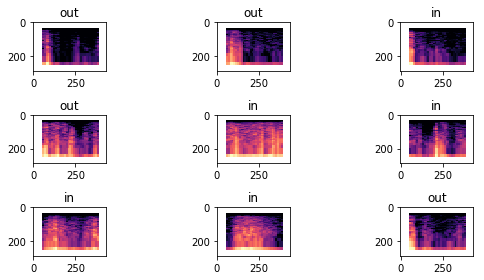

In [0]:
# random_seed = 3
# data = ImageList.from_folder(path_gdrive_train_img).split_by_rand_pct(seed=random_seed).label_from_folder().databunch()
# data.show_batch(3, figsize=(8,4), hide_axis=False)
# learner = cnn_learner(data, models.resnet34, metrics=accuracy, callback_fns=ShowGraph)
# learner.load(path_gdrive_models + 'resnet34_76%')

In [0]:
# learner.lr_find()
# learner.recorder.plot()

In [0]:
# learner.fit_one_cycle(100, max_lr=slice(1e-2,1e-1))

In [0]:
#learner.save(path_gdrive_models + 'resnet34_76%')

In [0]:
valid_in_files = []
valid_out_files = []

for filename in os.listdir(path_gdrive_valid_img_in):
    if filename.endswith("png"):
      valid_in_files.append(path_gdrive_valid_img_in + filename)
      
for filename in os.listdir(path_gdrive_valid_img_out):
    if filename.endswith("png"):
      valid_out_files.append(path_gdrive_valid_img_out + filename)
      
valid_in_imgs = []
for valid_in_file in valid_in_files:
  valid_in_imgs.append(open_image(valid_in_file))
  
valid_out_imgs = []
for valid_out_file in valid_out_files:
  valid_out_imgs.append(open_image(valid_out_file))
  
for i in range(len(valid_in_imgs)):
  print('results of ' + str(i))
  learner.predict(valid_in_imgs[i])
  print('\n')

print('--------------------')
print('\n')

for i in range(len(valid_out_imgs)):
  print('results of ' + str(i))
  learner.predict(valid_out_imgs[i])
  print('\n')

# Try HHT

EMD 

# Try scikit learn

In [0]:
#@title run feature extraction { run: "auto", form-width: "25%" }
run_feature_extraction = False #@param {type:"boolean"}

if(run_feature_extraction):
  temp_in_clips = []
  temp_in_files = []

  
#   loading clips

  for filename in os.listdir(path_gdrive_train_audio_in):
      if filename.endswith("wav"):
        temp_in_files.append(filename)
        temp_in_clip, temp_sr = librosa.load(path_gdrive_train_audio_in + filename)
        temp_in_clips.append(temp_in_clip)


  temp_out_clips = []
  temp_out_files = []

  for filename in os.listdir(path_gdrive_train_audio_out):
      if filename.endswith("wav"):
        temp_out_files.append(filename)
        temp_out_clip, temp_sr = librosa.load(path_gdrive_train_audio_out + filename)
        temp_out_clips.append(temp_out_clip)

In [0]:
# bandpass_filtered_clips = bandpass_filter(temp_out_clips)
# pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)
# hilbert_transformed_clips = hilbert_transform(pre_emphasized_clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
# normalised_clips = normalise(hilbert_transformed_clips)

In [0]:
# features_group = []

# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.spectral_bandwidth(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  

# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.spectral_centroid(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.spectral_contrast(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.spectral_flatness(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.spectral_rolloff(clip)
#   features.append(np.mean(feature))
# features_group.append(features) 


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.mfcc(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.mfcc(clip)
#   feature = librosa.feature.delta(feature, mode='nearest')  
#   features.append(np.mean(feature))
# features_group.append(features)


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.mfcc(clip)
#   feature = librosa.feature.delta(feature, mode='nearest', order=2)  
#   features.append(np.mean(feature))
# features_group.append(features)

# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.rms(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  

# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.rmse(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  

# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.poly_features(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  

# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.tonnetz(clip)
#   features.append(np.mean(feature))
# features_group.append(features)  


# features = []
# for clip in normalised_clips:
#   feature = librosa.feature.zero_crossing_rate(clip)
#   features.append(np.mean(feature))
# features_group.append(features) 



# features = []
# for clip in normalised_clips:
#   feature = np.sum(np.square(clip))
#   features.append(feature)
# features_group.append(features) 

# np.savetxt("features_group_out_test.csv", np.transpose(features_group), delimiter=",")

In [0]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [0]:
df = pd.read_csv(path_gdrive + 'breathing_feature_dataset.csv')
test_df = pd.read_csv(path_gdrive + 'test_breathing_feature_dataset.csv')

In [0]:
df.head()

,label,bandwidth_mean,centroid_mean,contrast_mean,flatness_mean,rolloff_mean,mfcc_mean,mfcc_delta_mean,mfcc_delta_delta_mean,rms_mean,rmse_mean,poly_features_mean,tonnetz_mean,zero_crossing_rate_mean,bandwidth_std,centroid_std,contrast_std,flatness_std,rolloff_std,mfcc_std,mfcc_delta_std,mfcc_delta_delta_std,rms_std,rmse_std,poly_features_std,tonnetz_std,zero_crossing_rate_std,energy
0,0,1865.164782,1703.019750,14.9,0.004612,3310,-1.350,-0.280318,0.021222,0.084806,0.084806,1.046822,0.008278,0,143.031891,216.535065,4.181791,0.001999,379.780250,52.314129,3.232323,1.368368,0.068487,0.068487,1.778071,0.033969,0.0,249.0
1,0,1841.489392,1538.309435,14.2,0.004451,3260,-1.030,0.076388,0.014175,0.071398,0.071398,0.886110,-0.006239,0,238.540644,393.965766,4.232521,0.003494,651.646234,56.629783,3.504878,2.256501,0.040563,0.040563,1.237467,0.035196,0.0,150.0
2,0,1615.049716,1364.157428,14.3,0.003203,2790,-1.660,-0.014437,0.025348,0.068129,0.068129,0.886644,0.000138,0,350.031473,455.817818,4.244717,0.003158,852.785514,62.268289,4.158274,2.565823,0.034689,0.034689,1.192474,0.030693,0.0,128.0
3,0,1907.982910,1777.478431,14.6,0.005377,3470,-0.745,0.065038,-0.011545,0.108661,0.108661,1.365765,0.007660,0,170.153563,306.437781,4.588391,0.002115,471.381013,50.580904,3.504385,1.574866,0.097834,0.097834,2.265669,0.038725,0.0,479.0
4,0,2054.505064,1879.887303,14.3,0.006994,3770,1.760,0.134795,0.008966,0.116312,0.116312,1.486280,0.004329,0,109.164990,241.125501,4.234589,0.002465,301.987150,39.719231,2.523597,1.677767,0.046176,0.046176,1.769156,0.030893,0.0,338.0


In [0]:
test_df.head()

,label,bandwidth_mean,centroid_mean,contrast_mean,flatness_mean,rolloff_mean,mfcc_mean,mfcc_delta_mean,mfcc_delta_delta_mean,rms_mean,rmse_mean,poly_features_mean,tonnetz_mean,zero_crossing_rate_mean,bandwidth_std,centroid_std,contrast_std,flatness_std,rolloff_std,mfcc_std,mfcc_delta_std,mfcc_delta_delta_std,rms_std,rmse_std,poly_features_std,tonnetz_std,zero_crossing_rate_std,energy
0,0,1752.417867,1596.974119,15.153502,0.003320,2974.273682,1.220389,0.186088,0.017576,0.162176,0.162176,1.974889,0.003760,0.0,140.0,216.0,4.32,0.00153,351.0,43.2,2.93,1.120,0.1030,0.1030,2.70,0.0299,0.0,809.0
1,0,1805.669530,1643.000030,14.941525,0.003600,3085.365434,2.245212,0.058263,-0.006370,0.169820,0.169820,2.071274,0.001514,0.0,134.0,185.0,4.16,0.00154,283.0,39.5,2.14,0.938,0.0859,0.0859,2.55,0.0321,0.0,797.0
2,0,1815.980268,1658.232788,14.882925,0.003631,3108.366810,4.219746,0.049010,0.002882,0.259446,0.259446,3.190323,0.006105,0.0,99.1,165.0,4.32,0.00130,191.0,33.3,1.60,0.797,0.0927,0.0927,3.58,0.0292,0.0,1700.0
3,0,1787.995030,1635.022559,14.780505,0.003499,3071.417791,3.195650,0.139820,-0.002922,0.217430,0.217430,2.700135,0.006140,0.0,97.3,160.0,4.56,0.00128,215.0,36.2,2.17,0.876,0.0907,0.0907,3.16,0.0301,0.0,1220.0
4,0,1739.879730,1539.878193,15.357312,0.002953,2980.391069,0.095534,0.017391,-0.020034,0.121553,0.121553,1.417929,0.004668,0.0,237.0,337.0,4.51,0.00230,522.0,50.6,3.61,1.690,0.0866,0.0866,2.07,0.0333,0.0,501.0


In [0]:
feature_cols = ['bandwidth_mean', 
                'contrast_mean', 
                'rolloff_mean', 
                'mfcc_mean', 
                'mfcc_delta_mean', 
                'mfcc_delta_delta_mean', 
                'rms_mean', 'rmse_mean', 
                'poly_features_mean', 
                'tonnetz_mean',
                'energy']
label_col = ['label']
X = df[feature_cols]
y = df[label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test_2 = test_df[feature_cols]
y_test_2 = test_df[label_col]

In [0]:
rfc = RandomForestClassifier(n_estimators=40, random_state=0)  
rfc.fit(X_train, y_train.values.ravel())  
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

[[10  3]
 [ 1  7]]
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.70      0.88      0.78         8

    accuracy                           0.81        21
   macro avg       0.80      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

0.8095238095238095


In [0]:
rfc.score(X_test_2, y_test_2)

0.5384615384615384

<Figure size 1440x360 with 0 Axes>

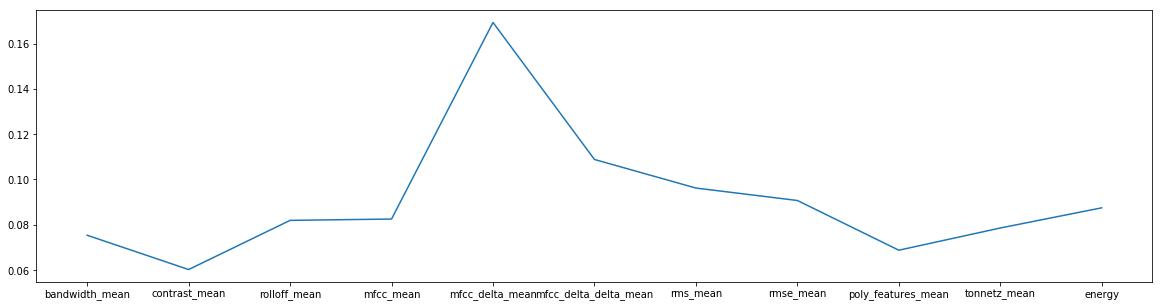

In [0]:
feature_importances = rfc.feature_importances_
plt.figure(figsize = (20,5))
plt.plot(feature_cols, feature_importances)

In [0]:
from sklearn.svm import SVC

In [0]:
feature_cols = ['bandwidth_mean', 
                'rolloff_mean',                 
                'mfcc_mean', 
                'mfcc_delta_mean', 
                'mfcc_delta_delta_mean',
                'poly_features_mean', 
                'rms_mean']
               
label_col = ['label']
X = df[feature_cols]
y = df[label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test_2 = test_df[feature_cols]
y_test_2 = test_df[label_col]

In [0]:
random_seed = 3

svc = SVC(kernel='linear', C=4,  random_state=random_seed)
svc.fit(X_train, y_train.values.ravel())
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=3,
    shrinking=True, tol=0.001, verbose=False)

[[7 6]
 [2 6]]
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.50      0.75      0.60         8

    accuracy                           0.62        21
   macro avg       0.64      0.64      0.62        21
weighted avg       0.67      0.62      0.62        21

0.6190476190476191


In [0]:
svc.score(X_test_2, y_test_2)

0.5384615384615384

# **Clinic dataset**

create csv for all annotations

In [0]:
import pandas as pd

path_gdrive_clinic_dataset = path_gdrive + 'clinic_dataset/'
path_gdrive_clinic_dataset_originals = path_gdrive_clinic_dataset + 'originals/'
path_gdrive_clinic_dataset_segmented = path_gdrive_clinic_dataset + 'segmented/'
path_gdrive_clinic_dataset_segmented_full = path_gdrive_clinic_dataset_segmented + 'full/'

In [0]:
from IPython.display import clear_output

annotations_filenames = []

header = {
          'start':[],
          'end':[],
          'crackles':[],
          'wheezes':[],
          'wav_name':[]
         }

annotations = pd.DataFrame(header)
i = 0
i_total = len(os.listdir(path_gdrive_clinic_dataset_originals))
for filename in os.listdir(path_gdrive_clinic_dataset_originals):
  
  i = i+1
  if filename.endswith('txt'):
    print(str(i) + '/' + str(i_total))
    print(filename)
    if(i%10 == 0):
      clear_output()
    annotations_filenames.append(filename)
    
    annotation_df = pd.read_csv(path_gdrive_clinic_dataset_originals + filename,  sep='\t', names=header, index_col=False)
    annotation_df['wav_name'] = filename.split('.')[0]+'.wav'    
    annotations = annotations.append(annotation_df)

1831/1840
138_2p2_Pr_mc_AKGC417L.txt
1833/1840
135_2b1_Tc_mc_LittC2SE.txt
1834/1840
112_1p1_Pr_sc_Litt3200.txt
1835/1840
207_3b2_Tc_mc_AKGC417L.txt
1836/1840
200_2p4_Pl_mc_AKGC417L.txt
1838/1840
170_1b4_Pl_mc_AKGC417L.txt
1839/1840
122_2b3_Tc_mc_LittC2SE.txt


In [0]:
annotations = annotations.reset_index()
annotations = annotations.drop(columns = ['index'])
annotations.to_csv(path_gdrive_clinic_dataset+'annotations.csv')

create segmentations of full cycle

In [0]:
cycle_duration_threshold = 5

counter = 0

for index, annotation in annotations.iterrows():
  if((annotation['end'] - annotation['start']) <= cycle_duration_threshold):
    wav, sr = librosa.load(path_gdrive_clinic_dataset_originals+annotation['wav_name'], sr=None)
    segmented_wav = wav[int(annotation['start']*sr) : int(annotation['end']*sr)]
    librosa.output.write_wav(path_gdrive_clinic_dataset_segmented_full+str(counter)+'_'+annotation['wav_name'], segmented_wav, sr)
    counter = counter + 1
    
    print(str(counter) + '/' + str(len(annotations)))
    print(annotation['wav_name'])
    if(counter%10 == 0):
      clear_output()

6661/6898
122_2b3_Tc_mc_LittC2SE.wav
6662/6898
122_2b3_Tc_mc_LittC2SE.wav
6663/6898
122_2b3_Tc_mc_LittC2SE.wav
6664/6898
122_2b3_Tc_mc_LittC2SE.wav
6665/6898
122_2b3_Tc_mc_LittC2SE.wav


read each of the full segementation and create (inghalation, transition and exhaltion) according to percentages

In [0]:
perc_inhalation = 0.4
perc_exhalation = 0.4
perc_transition = 1 - perc_inhalation - perc_exhalation

inhalation_start = 0
inhalation_end = perc_inhalation

exhalation_start = (1 - perc_exhalation)
exhalation_end = 1

transition_start = perc_inhalation
transition_end = (1 - perc_exhalation)

path_gdrive_clinic_dataset_segmented_inhalation = path_gdrive_clinic_dataset_segmented + '0.4_0.4/' + 'inhalation/'
path_gdrive_clinic_dataset_segmented_transition = path_gdrive_clinic_dataset_segmented + '0.4_0.4/' + 'transition/'
path_gdrive_clinic_dataset_segmented_exhalation = path_gdrive_clinic_dataset_segmented + '0.4_0.4/' + 'exhalation/'

for filename in os.listdir(path_gdrive_clinic_dataset_segmented_full):
  if filename.endswith('wav'):
    wav, sr = librosa.load(path_gdrive_clinic_dataset_segmented+filename, sr=None)
    
    total_duration = len(wav)
    inhalation_start = int(inhalation_start * total_duratioin)
    inhalation_end = int(inhalation_end * total_duratioin)
    transition_start = int(transition_start * total_duratioin)
    transition_end = int(transition_end * total_duratioin)
    exhalation_start = int(exhalation_start * total_duratioin)
    exhalation_end = int(exhalation_end * total_duratioin)
    
    wav_inhalation = wav[inhalation_start : inhalation_end]
    wav_transition = wav[transition_start : transition_end]
    wav_exhalation = wav[exhalation_start : exhalation_end]
    
    librosa.output.write_wav
    (
        path_gdrive_clinic_dataset_segmented_inhalation,
        wav_inhalation,
        sr
    )
    
    librosa.output.write_wav
    (
        path_gdrive_clinic_dataset_segmented_transition,
        wav_transition,
        sr
    )
    
    librosa.output.write_wav
    (
        path_gdrive_clinic_dataset_segmented_exhalation,
        wav_exhalation,
        sr
    )

6665

FileNotFoundError: ignored